In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from scipy import stats

import plotly.io as pio
pio.renderers.default = "png"

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split

from statsmodels import api as sm

from functions import df_engineered

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
feature_selection = ['ExterQual', 'BsmtQual', 'KitchenQual', 'OverallQual', 
                    'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'FullBath', 
                    'HouseAge', 'TotRmsAbvGrd', 'OverallCond',  'FlrSF1st', 'FlrSF2nd',
                    'Fireplaces', 'LotFrontage', 'LotArea', 'MSSubClass', 'GoodGarageType', 
                    'BsmtUnfSF', 'Zone', 'Location_2', 'Location_3', 'Location_4',
                    'CulDSac', 'Exterior1st_top', 'ExQual', 'RemodAge', 'LargerHouse', 'Remod']
                        

In [3]:
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
df.rename(columns = {'1stFlrSF':'FlrSF1st', '2ndFlrSF':'FlrSF2nd'}, inplace = True)
print('df shape:', df.shape)

data = df_engineered(df)
#df = data['train']
#df_2010 = data['test']

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data[['SalePrice']], test_size=0.30, random_state=42)

df shape: (2580, 80)


# Model

### Standardization

In [4]:
scaler = StandardScaler()

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = np.log(y_train.reset_index(drop=True)['SalePrice'])
y_test = np.log(y_test.reset_index(drop=True)['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[feature_selection]), columns=X_train[feature_selection].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[feature_selection]), columns=X_test[feature_selection].columns)

## Linear Regression

In [5]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9166 0.9177 0.9183 0.9266 0.9452]
Mean shuffled cross validation score: 0.9249
RMSE Shuffled cross validation score: [0.1016 0.1061 0.1002 0.1015 0.0858]
RMSE Mean shuffled cross validation score: 0.099


In [6]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9249
RMSE Test score: 0.1025


In [7]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17438.834158726982
18127.28782024905


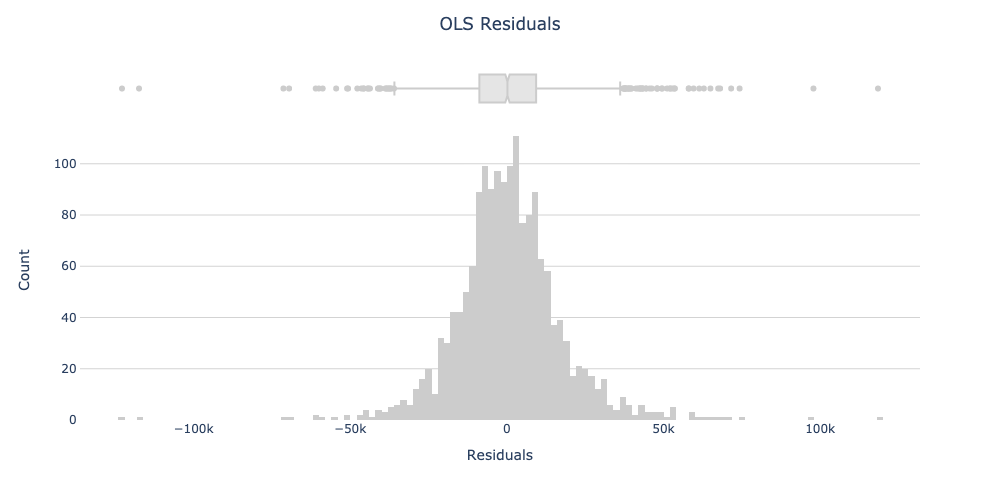

In [8]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                pd.concat([X_train, np.exp(y_train)], axis=1), 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='OLS Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


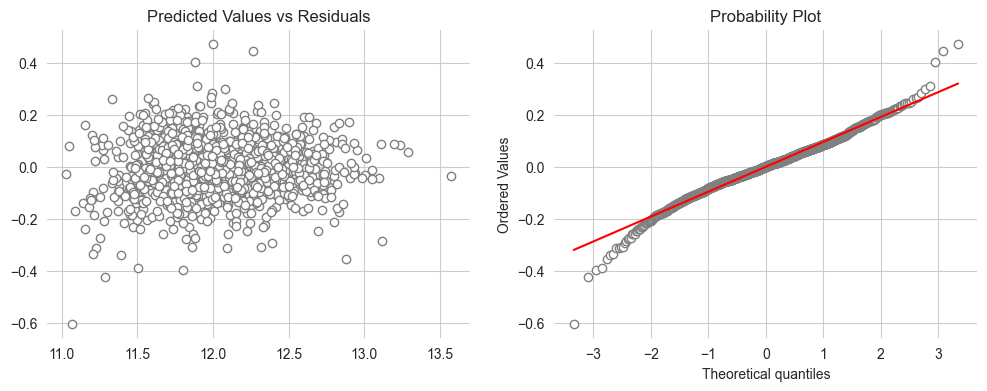

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [10]:
res = stats.shapiro(residuals)
res.statistic

0.9797509908676147

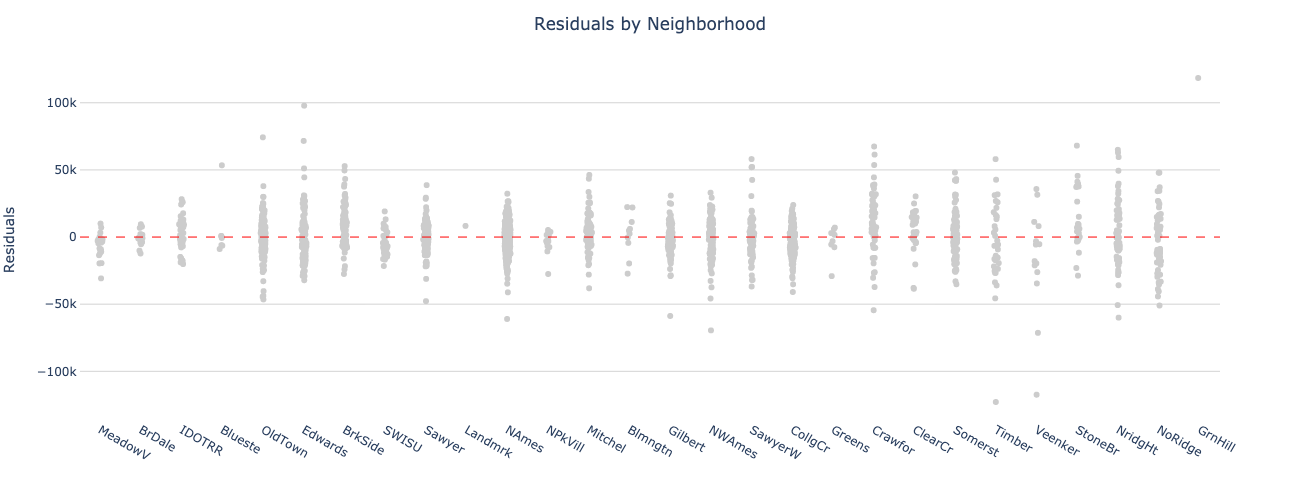

In [11]:
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

fig = px.strip(
            results, 
            x='Neighborhood', 
            y='residual',
            category_orders={'Neighborhood':order},
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by Neighborhood', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

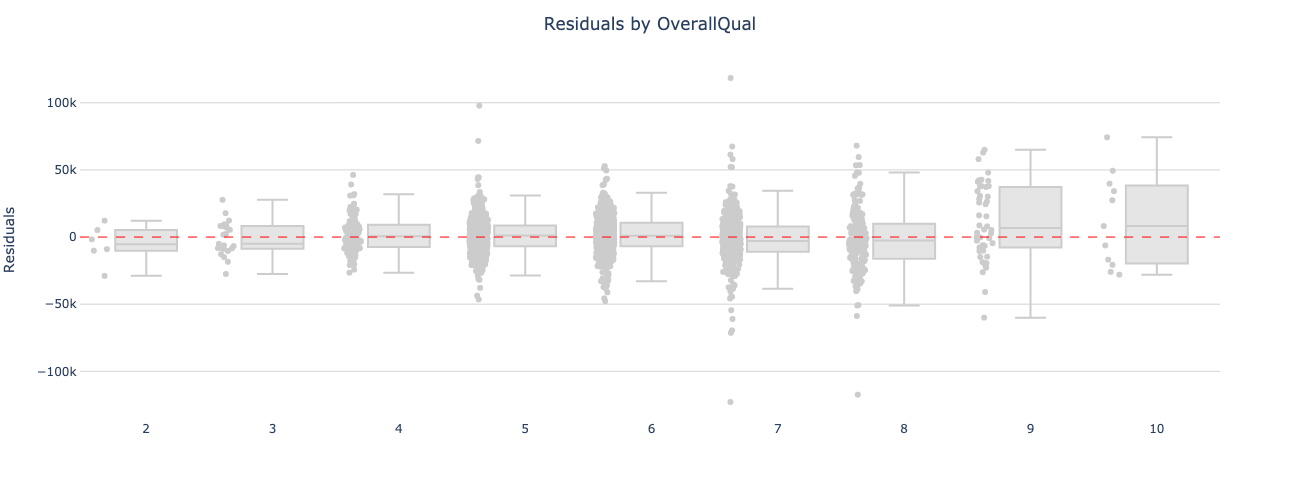

In [12]:
order = results.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            results, 
            x='OverallQual', 
            y='residual',
            category_orders={'OverallQual':order},
            points="all",
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by OverallQual', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

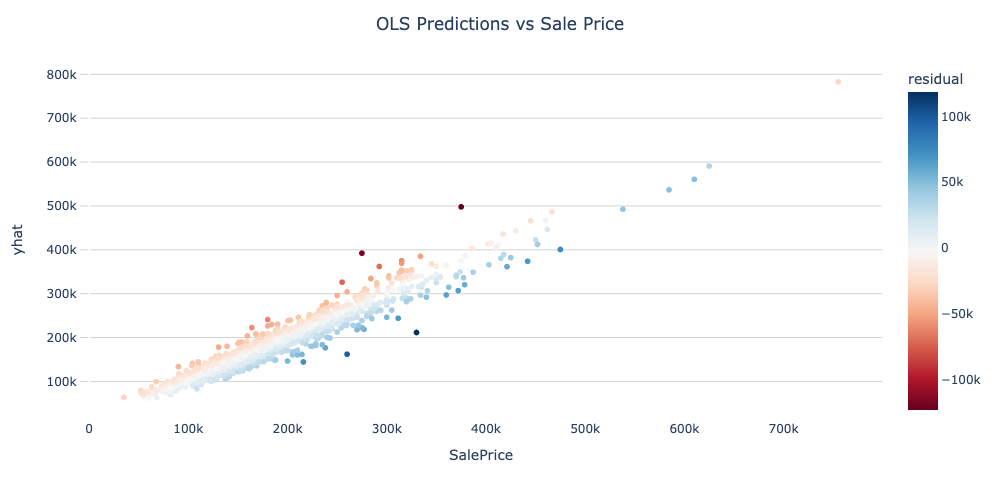

In [13]:
fig = px.scatter(
            results, 
            x='SalePrice', 
            y='yhat',
            color='residual',
            color_continuous_scale='RdBu',
            width=1000)

fig.update_layout(
            title='OLS Predictions vs Sale Price', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
            
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray')
            
fig.show()

## Lasso

In [14]:
lasso = LassoCV(cv=3)
lasso.fit(X_train_scaled, y_train)

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_lasso)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Best alpha: 0.0007874904600735018
RMSE: 0.10244944213106164


In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [16]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17390.571388044922
18067.282401428627


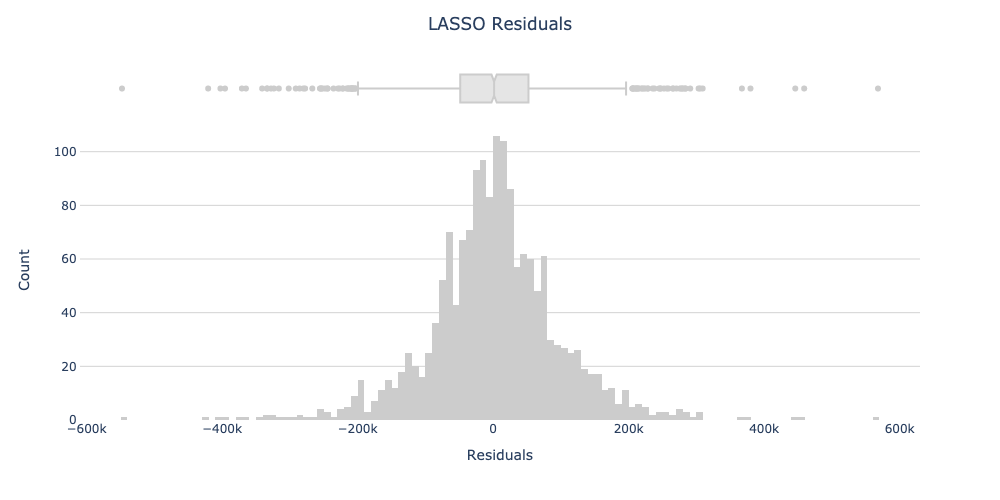

In [17]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='LASSO Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


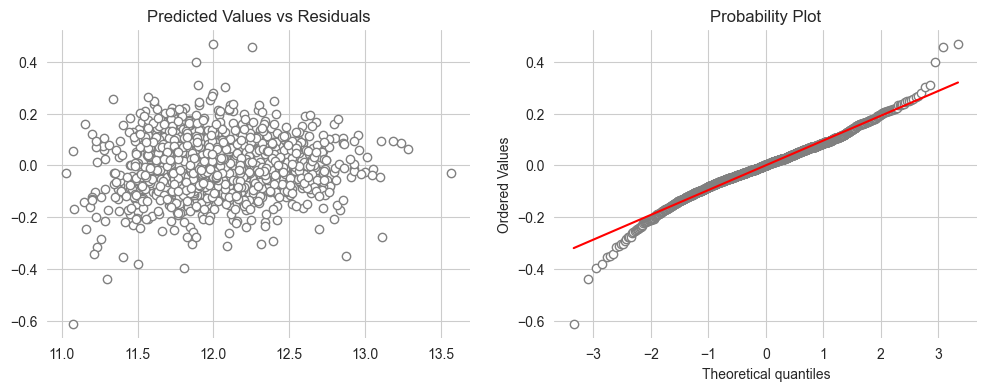

In [18]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [19]:
res = stats.shapiro(residuals)
res.statistic

0.9787005186080933

## Ridge

In [20]:
from sklearn.linear_model import Lasso, Ridge
ridge = RidgeCV(cv=3)
ridge = Ridge(alpha=10)
ridge.fit(X_train_scaled, y_train)

# best_alpha = ridge.alpha_
# print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_ridge)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
RMSE: 0.10246140343262282


In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ridge, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

ridge.coef_

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


array([-0.00260658,  0.01726546,  0.02187945,  0.08095125,  0.06797201,
        0.07196036,  0.03227933, -0.00766208, -0.04916196,  0.00139935,
        0.05407157,  0.0394075 ,  0.04437164,  0.02677317,  0.00716225,
        0.01922606, -0.0135858 ,  0.00879101, -0.04001292,  0.01991079,
        0.010177  ,  0.03275532,  0.0418276 ,  0.00499626,  0.0019501 ,
        0.00455601, -0.01279114,  0.00919559, -0.00498952])

In [22]:
yhat_train = ridge.predict(X_train_scaled)
yhat_test = ridge.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17421.352135986446
18117.502020466763


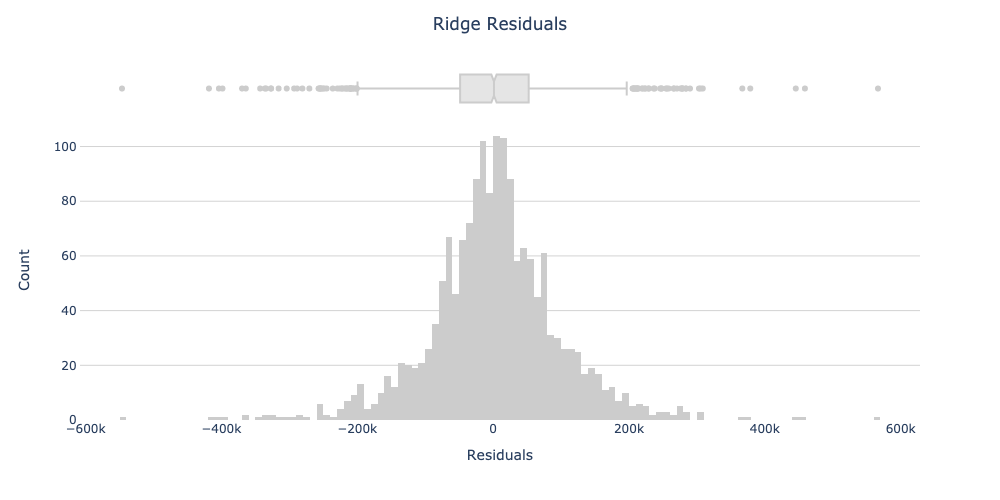

In [23]:
yhat = ridge.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='Ridge Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


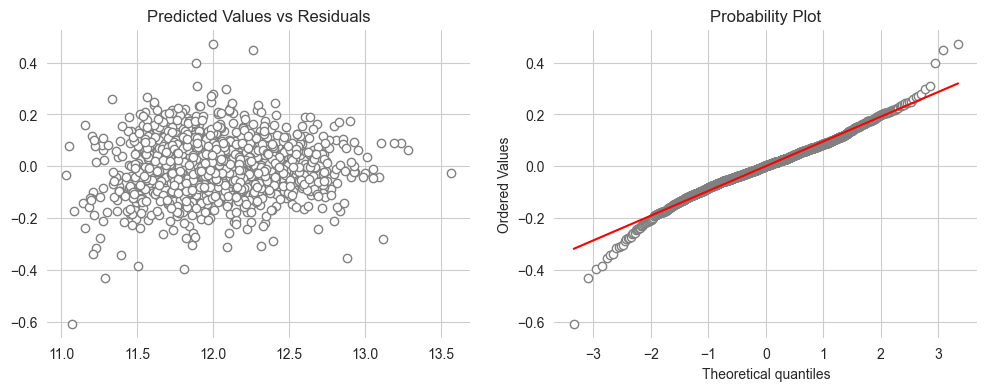

In [24]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [25]:
res = stats.shapiro(residuals)
res.statistic

0.9793475270271301

## Stats model

In [26]:
model = sm.OLS.from_formula('SalePrice ~ GrLivArea + Location_4 + GrLivArea:Location_4', data=data).fit()
print(model.params)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intercept                       48046.380526
Location_4[T.True]             -24105.600305
GrLivArea                          78.012211
GrLivArea:Location_4[T.True]       55.070900
dtype: float64


In [43]:
X_train_scaled_sm = sm.add_constant(X_train_scaled)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + KitchenQual + OverallQual +\
                    GrLivArea + TotalBsmtSF  + GarageArea +\
                    HouseAge  + OverallCond + FlrSF1st + FlrSF2nd +\
                    Fireplaces + LotFrontage + LotArea + MSSubClass +\
                    BsmtUnfSF + Zone + Location_3 + Location_4 +\
                    CulDSac + RemodAge +\
                    HouseAge:Zone + GarageArea:GoodGarageType', data=pd.concat([X_train_scaled_sm, y_train], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=0/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

print(final.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     990.4
Date:                Wed, 12 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:14:22   Log-Likelihood:                 1542.2
No. Observations:                1678   AIC:                            -3038.
Df Residuals:                    1655   BIC:                            -2914.
Df Model:                          22                                         
Covariance Type:            nonrobust  

In [44]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17491.259483936963
17981.825404182746
